<h1 align=center>Proyecto Individual #2</h1>
<hr>
<h3 align=center>Modelo de Predicción de Machine Learning</h3>
<h4 align=center>Daniel Muñoz López</h4>
<h4 align=center>Dataft05</h4>

<h2 align=center>Análisis Exploratorio de Datos (EDA)</h2>

### Levantamiento del dataset de entrenamiento

1. Se importan las librerías necesarias.
2. Se hace el llamado con pandas del dataset que será usado para entrenar el modelo.
3. Se realiza la codificación de variables no numéricas (strings), para poder ser analizadas de manera más precisa.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from matplotlib import cm

data_train = pd.read_csv('hospitalizaciones_train.csv', sep=',') #Importanción del dataset
data_train['Type of stay'] = np.where(data_train['Stay (in days)']>8,1,0) #Creación de la columna binaria: Más de 8 días o no.

#Decodificación de las variables que no son números en números para el dataframe de trabajo
encoder = preprocessing.LabelEncoder()
for column in data_train.columns:
    if data_train[column].dtype != ('int64' or 'float'):
        data_train[column]=encoder.fit_transform(data_train[column])

Debido al enfoque del problema, se determina que la predicción debe ser de tipo categórica, ya que la misma analizará si la estadía debe ser mayor o menor que 8 días (carácter binario).

### Creación y lectura del mapa de calor

La visualización de las correlaciones en el mapa de calor son una gran herramienta para descartar o elegir variables que pueden ser útiles en nuestro modelo de machine learning para aportarnos información importante. Al elegir las variables correctas, permiten que la creación del modelo sea mucho más óptima y dando resultados más fiables.

La variables con mejor coeficiente de correlación respecto de la varaible categorizada que habla de la estadía mayor a 8 días (Type of Stay), son:

1. Department.
2. doctor_name.
3. Age.
4. gender.

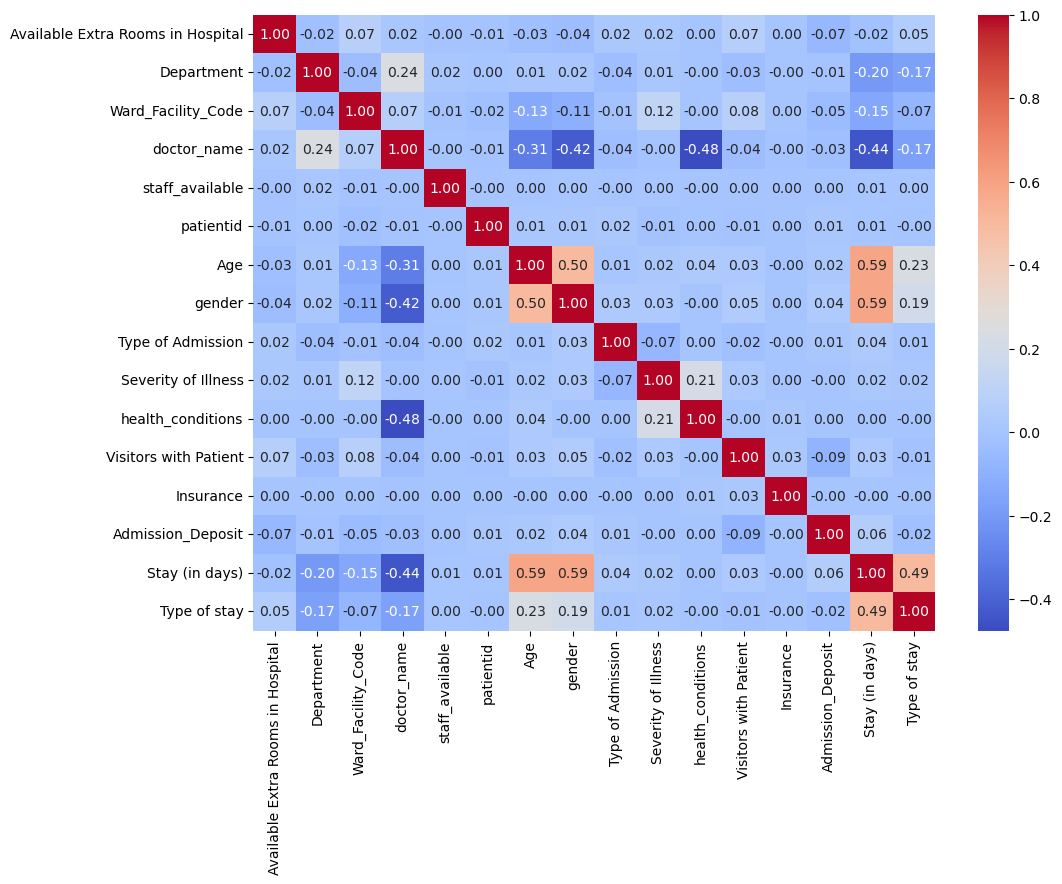

In [3]:
correlation = data_train.corr() #Cálculo delas correlaciones del dataframe para creación del mapa de calor
plt.figure(figsize = (11,8))
sns.heatmap(correlation, cbar = True,  square = False, annot=True, fmt= '.2f',cmap= 'coolwarm')
y = data_train['Type of stay']
important_features = data_train[['doctor_name','Department','Age', 'gender']]

<hr>
<h2 align=center>Elección de Modelos</h2>

La elección de un modelo de machine learning dependerá que de tan alto sea su valor en la métrica *accuracy*.

### Regresión Logística

Es un tipo de regresión lineal que sirve para analizar y clasificar, se modela bajo la famosa función **matemática sigmoide**. Sin embargo su uso es limitado, porque no puede usar varias variables, solo 1vs1.

In [10]:
x = np.array(data_train['Department'])
x.reshape(-1,1)

array([[2],
       [2],
       [2],
       ...,
       [2],
       [2],
       [2]])

In [12]:
from sklearn.linear_model import LogisticRegression
logistical_regression = LogisticRegression()
x = np.array(data_train['Age']).reshape(-1,1)
logistical_regression.fit(x,y)
from sklearn.metrics import accuracy_score 
y_pred = logistical_regression.predict(x)
print('El accuracy del modelo es:', accuracy_score(y, y_pred))

El accuracy del modelo es: 0.6042658536585366


<hr>

### Árbol de decisión

Es otro modelo para realizar clasificaciones, basándose en la forma de un árbol y sus ramas. Consiste en ir desplegando la categorización de las variables mediante nodos, de tal manera que cada dato va entrando a una subcategoría a medida que es evaluado por el modelo.

- Se analiza el hiperparámetro de profundidad y se  elige cual es el más óptimo para ser usado con un **cross validate**.

Para el modelo actual se puede ver gráficamente que el mejor valor de profundidad para ser usado es de **max_depth = 4**.

Completado: 100.0%


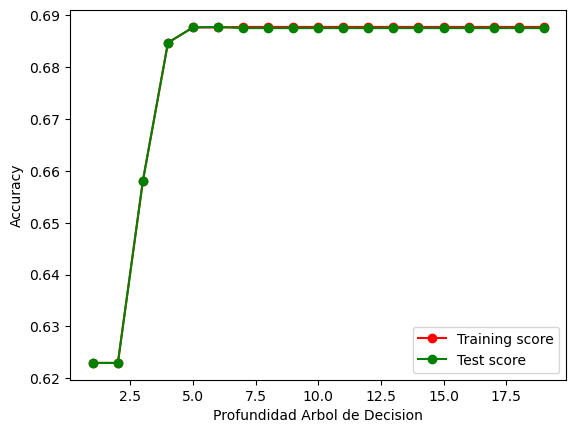

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_validate
from IPython.display import clear_output

tree_train_scores_mean = []
tree_train_scores_std = []
tree_test_scores_mean = []
tree_test_scores_std = []

y=data_train['Type of stay']
x=important_features

profundidades = np.arange(1,20,1)
i = 0
i_max = len(profundidades)
for profundidad in profundidades:
    i = i + 1
    tree_decision = DecisionTreeClassifier(max_depth=profundidad,random_state = 42)
    tree_scores = cross_validate(tree_decision, x, y, cv=5, return_train_score=True, n_jobs = -1)
    
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())
    
    clear_output(wait=True)
    print('Completado: ' + str(round(i / i_max * 100, 2)) + '%')

plt.plot(profundidades, tree_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(profundidades, tree_test_scores_mean, 'o-', color="g",
         label="Test score")

plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

### Elección de datos de entrenamiento y testeo del modelo

Precisión (accuracy) en el set de train: 0.6848641114982579
Precisión (accuracy) en el set de testeo: 0.684219512195122


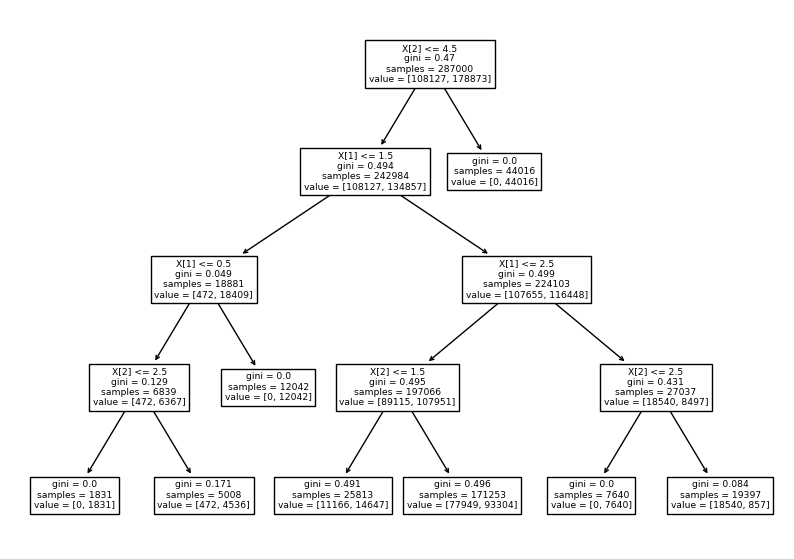

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x.values, y.values, test_size=0.3, random_state=42)

tree_decision = DecisionTreeClassifier (max_depth = 4, random_state = 42)

tree_decision.fit(x_train,y_train)
print(f'Precisión (accuracy) en el set de train: {tree_decision.score(x_train,y_train)}')
print(f'Precisión (accuracy) en el set de testeo: {accuracy_score(tree_decision.predict(x_test),y_test)}')

plt.figure(figsize=(10,7))
tree.plot_tree(tree_decision.fit(x_train,y_train))
plt.show()

In [12]:
for i in range(len(important_features.columns)):
    print(important_features.columns[i],tree_decision.feature_importances_[i])

doctor_name 0.0
Department 0.28424517866572024
Age 0.7157548213342798
gender 0.0


# Matriz de Confusión

La matriz de confusión permite analizar que tan buenas han sido las predicciones del modelo comparado con los valores reales. Para el presente proyecto usaremos dos métricas:

- Recall.
- Accuracy.

- El valor **1** representa los casos positivos.
- El valor **0** representa los casos negativos.

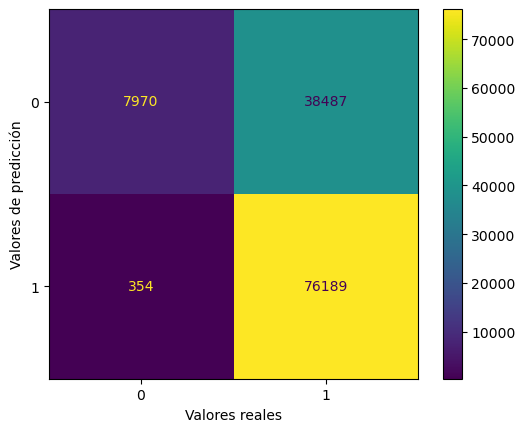

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = tree_decision.predict(x_train)
y_test_pred = tree_decision.predict(x_test)

matrix = confusion_matrix(y_train, y_train_pred)
matrix_2 = confusion_matrix(y_test, y_test_pred)

cm_display = ConfusionMatrixDisplay(matrix)
cm_display_2 = ConfusionMatrixDisplay(matrix_2)

cm_display_2.plot()
plt.xlabel('Valores reales')
plt.ylabel('Valores de predicción')
plt.show()

## Métricas
Accuracy y Exhaustividad (Recall).

In [15]:
from sklearn.metrics import recall_score

#Accuracy
exactitud = accuracy_score(y_test, y_test_pred)
print('Accuracy:', exactitud)

#Recall
precision = recall_score(y_test, y_test_pred)
print('Precicisón:', precision)


Accuracy: 0.684219512195122
Precicisón: 0.9953751486092784


## Pipeline

Creación del Pipeline

In [ ]:
# Importamos las librerías necesarias

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import tree

#Creamos el primer pipeline
pipe_lr = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=2)),
            ('clf', LogisticRegression(random_state=42))])

# Creamos el segundo pipeline
pipe_dt = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=2)),
            ('clf', DecisionTreeClassifier(random_state=42))])

# Los guardamos en una lista
pipelines = [pipe_lr, pipe_dt]

# Hacemos un diccionario para fines organizativos
pipe_dict = {0: 'Regresión Logística', 1: 'Árbol de decisión'}

# Entrenamos   x_train, x_test, y_train, y_test
for pipe in pipelines:
    pipe.fit(x_train, y_train)

# Evaluamos
for idx, val in enumerate(pipelines):
    print('%s pipeline accuracy en test: %.3f' % (pipe_dict[idx], val.score(x_test, y_test)))

# Identificamos el mejor modelo para el set de testeo
best_acc = 0.0
best_clf = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
    if val.score(x_test, y_test) > best_acc:
        best_acc = val.score(x_test, y_test)
        best_pipe = val
        best_clf = idx
print('Modelo con el mejor accuracy: %s' % pipe_dict[best_clf])

# Guardamos el pipeline en un archivo
import joblib #pickle es alternativa

joblib.dump(best_pipe, 'Mejor_pipeline.pkl', compress=1)
print('Pipeline de %s guardado a archivo' % pipe_dict[best_clf])

best_model = joblib.load('Mejor_pipeline.pkl')

best_model.fit(x_train,y_train)
best_model.score(x_test, y_test)

Regresión Logística pipeline accuracy en test: 0.595
Árbol de decisión pipeline accuracy en test: 0.687
Modelo con el mejor accuracy: Árbol de decisión
Pipeline de Árbol de decisión guardado a archivo


0.6871626016260163

<hr>

<h2 align=center>Trabajo Predictivo</h2>

### Levantamiento del Dataset

In [ ]:
data = pd.read_csv('hospitalizaciones_test.csv') #Importe de datos

#Normalización de columnas tipo string, todo en minúsculas
for column in data.columns:
    if data[column].dtype == ('object'):
        data[column]=data[column].str.lower()

#Cambio de variables string a números
encoder = preprocessing.LabelEncoder()
for column in data.columns:
    if data[column].dtype != ('int64' or 'float'):
        data[column]=encoder.fit_transform(data[column])
data

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit
0,3,1,5,4,10,2858,2,0,1,2,5,2,0,52469
1,2,4,4,1,4,65657,5,0,1,2,0,2,1,24227
2,2,2,4,1,7,45598,5,2,1,2,4,3,0,75017
3,2,1,5,4,1,31132,2,0,1,2,4,2,1,19861
4,2,0,0,1,7,125021,5,0,1,0,1,2,0,53798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,4,1,5,6,2,43001,1,0,1,1,3,3,0,23729
89996,13,1,5,4,8,85601,3,0,0,2,5,2,0,45398
89997,2,1,1,6,3,22447,1,0,0,2,3,2,0,74998
89998,2,2,0,1,1,29957,6,0,1,0,1,2,0,49049


#### Predicción y creación del archivo con los resultados

In [ ]:
important_features = data[['doctor_name','Department','Age', 'gender']]
y = tree_decision.predict(important_features)
prediction = pd.DataFrame(y.reshape(-1,1), columns=['pred'])
prediction.to_csv('damul90.csv', index=False)

c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
